# Modelling patch-clamp experiments: filters

In the [last notebook](./artefacts-2-compensation.ipynb) we updated our model of the patch-clamp amplifier with a variety of _compensation_ circuites.
In this notebook ....




Here, we will introduce the ODEs for filtering without explanation.
The ODEs are derived and discussed in [Appendix A5](./appendix-A5-bessel-filter-odes.ipynb), 
Bessel filters in general are treated in [Appendix A4](./appendix-A4-bessel-filters.ipynb), and the necessary Laplace transformations and filters in general are discussed in [Appendix A2](./appendix-A2-laplace-and-filters.ipynb).

As in the EPC-9

<img src="resources/patch-comp-8-filters.png" style="margin:auto" />

_**Figure 1**: Model with filters as in the EPC-9._

Approximating all filters as first-order filters:

\begin{align}
6.1. && C_m\dot{V}_m = \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} - \frac{V_m - E_\text{leak}}{R_\text{leak}} - I
\end{align}

\begin{align}
6.2. && (C_p+C_f)\dot{V}_p = \frac{V_o - V_p}{R_f} - \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} + C_f\dot{V}_o + C_m^* \dot{V}_\text{est} + C_p^* \dot{V}_\text{ref}
\end{align}

\begin{align}
6.3. && \tau_a \dot{V}_o = V_\text{ref} - V_p
\end{align}

\begin{align}
6.4. && \dot{V}_\text{est} &= \frac{V_c - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
6.5. && \tau_\text{sum}\dot{V}_\text{ref} = V_c + \alpha \frac{R_s^*}{R_f}V_f + \beta R_s^* C_m^* \dot{V}_\text{est} - V_\text{ref}
\end{align}

\begin{align}
6.6. && \tau_\text{f1} \dot{V}_f = V_o - V_\text{ref} - V_f
\end{align}

\begin{align}
6.7. && \tau_\text{f2} R_f \dot{I}_\text{obs} = V_f - R_f I_\text{obs}
\end{align}

\begin{align}
6.8. && \tau_\text{fs} \dot{V}_c = V_s - V_c
\end{align}

#TODO: Look at r_series_tau() and EPC-10 manual page 58 on rs comp resistance. Is there _another_ filter between F1 and Rs comp??? In "artefacts-2" I equate this setting with the speed of the summing amp.

#TODO: As we're drawing it now, the speed of the summing amp filters Rc compensation AND the input stimulus. Could this be why the rise time is not 20us?

#Note: In Chon's version, tau_z ends up representing the effects of RfCf, F1, and F2 _on the output_. This is why he describes it as depending on the filter settings. It is a 1-pole representation of a 2+6+4 pole cascade.




### Myokit model with first-order filters

In [1]:
import myokit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
m1 = myokit.parse_model('''
[[model]]
amp.Vm = -80
amp.Vp = -80
amp.Vo = -80
amp.Ve = -80
amp.Vr = -80
amp.Vf = -80
amp.V_obs = -80
amp.Vc = -80

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
I = 10 [nS] * Vm
    in [pA]
alpha = 0.7
beta = alpha
Rs = 6e-3 [GOhm] in [GOhm]
Rs_est = 6e-3 [GOhm] in [GOhm]
Cm = 25 [pF] in [pF]
Cm_est = 23 [pF] in [pF]
Cp = 6 [pF] in [pF]
Cp_est = 5.5 [pF] in [pF]
Rf = 0.495 [GOhm] in [GOhm]
Cf = 0.16 [pF] in [pF]
tau_amp = 20e-6 [ms] in [ms]
tau_sum = 10e-3 [ms] in [ms]

# Voltage clamp and compensations
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vp) = ((Vo - Vp) / Rf - (Vp - Vm) / Rs +
            Cf * dot(Vo) + Cm_est * dot(Ve) + Cp_est * dot(Vr)
          ) / (Cp + Cf)
    in [mV]
dot(Vo) = (Vr - Vp) / tau_amp
    in [mV]
dot(Ve) = (Vc - Ve) / ((1 - beta) * Rs_est * Cm_est)
    in [mV]
dot(Vr) = (Vc + alpha * Rs_est / Rf * Vf + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum
    in [mV]

# Output filters
f1 = 10 [kHz] in [kHz]
f2 = 10 [kHz] in [kHz]
tau_f1 = 1 / (2 * 3.14159 * f1)
    in [ms]
tau_f2 = 1 / (2 * 3.14159 * f2)
    in [ms]
dot(Vf) = (Vo - Vr - Vf) / tau_f1
    in [mV]
dot(V_obs) = (Vf - V_obs) / tau_f2
    in [mV]
I_obs = V_obs / Rf
    in [pA]

# Input filter
tr = 0.04 [ms] in [ms]
tau_fs = tr / log(9)
    in [ms]
Vs = engine.pace * 1 [mV]
    in [mV]
dot(Vc) = (Vs - Vc) / tau_fs
    in [mV]
''')
m1.check_units(myokit.UNIT_STRICT)

### Myokit model with Bessel filters

In [20]:
m2 = myokit.parse_model('''
[[model]]
amp.Vm = -80
amp.Vp = -80
amp.Vo = -80
amp.Ve = -80
amp.Vr = -80
amp.Vf11 = -80
amp.Vf12 = -80
amp.Vf13 = -80
amp.Vf14 = -80
amp.Vf15 = -80
amp.Vf16 = -80
amp.V_obs1 = -80
amp.V_obs2 = -80
amp.V_obs3 = -80
amp.V_obs4 = -80
amp.Vc1 = -80
amp.Vc2 = -80

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
I = 10 [nS] * Vm
    in [pA]
alpha = 0.7
beta = alpha
Rs = 6e-3 [GOhm] in [GOhm]
Rs_est = 6e-3 [GOhm] in [GOhm]
Cm = 25 [pF] in [pF]
Cm_est = 23 [pF] in [pF]
Cp = 6 [pF] in [pF]
Cp_est = 5.5 [pF] in [pF]
Rf = 0.495 [GOhm] in [GOhm]
Cf = 0.16 [pF] in [pF]
tau_amp = 20e-6 [ms] in [ms]
tau_sum = 10e-3 [ms] in [ms]

# Voltage clamp and compensations
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vp) = ((Vo - Vp) / Rf - (Vp - Vm) / Rs +
            Cf * dot(Vo) + Cm_est * dot(Ve) + Cp_est * dot(Vr)
          ) / (Cp + Cf)
    in [mV]
dot(Vo) = (Vr - Vp) / tau_amp
    in [mV]
dot(Ve) = (Vc2 - Ve) / ((1 - beta) * Rs_est * Cm_est)
    in [mV]
dot(Vr) = (Vc2 + alpha * Rs_est / Rf * Vf16 + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum
    in [mV]

# Filter 1
f1 = 10 [kHz] in [kHz]
a1 = 2.7034 / (2 * 3.14159 * f1)
    in [ms]
dot(Vf11) = 26.514 / a1^2 * (Vo - Vr - Vf12) - 5.0319 / a1 * Vf11
    in [mV/ms]
dot(Vf12) = Vf11
    in [mV]
dot(Vf13) = 20.853 / a1^2 * (Vf12 - Vf14) - 7.4714 / a1 * Vf13
    in [mV/ms]
dot(Vf14) = Vf13
    in [mV]
dot(Vf15) = 18.801 / a1^2 * (Vf14 - Vf16) - 8.4967 / a1 * Vf15
    in [mV/ms]
dot(Vf16) = Vf15
    desc: The 6-pole filtered output
    in [mV]

# Filter 2
f2 = 10 [kHz] in [kHz]
a2 = 2.114 / (2 * 3.14159 * f2)
    in [ms]
dot(V_obs1) = 11.488 / a2^2 * (Vf16 - V_obs2) - 4.2076 / a2 * V_obs1
    in [mV/ms]
dot(V_obs2) = V_obs1
    in [mV]
dot(V_obs3) = 9.1401 / a2^2 * (V_obs2 - V_obs4) - 5.7924 / a2 * V_obs3
    in [mV/ms]
dot(V_obs4) = V_obs3
    desc: The 4-pole filtered output
    in [mV]
I_obs = V_obs4 / Rf
    in [pA]

# Input filter
tr = 0.04 [ms] in [ms]
a3 = 1.3616 * tr / log(9)
    in [ms]
Vs = engine.pace * 1 [mV]
    in [mV]
dot(Vc1) = 3 * ((Vs - Vc2) / a3^2 - Vc1 / a3)
    in [mV/ms]
dot(Vc2) = Vc1
    desc: The 2-pole filtered stimulus
    in [mV]
''')
m2.check_units(myokit.UNIT_STRICT)

In [21]:
p = myokit.Protocol()
p.add_step(level=-80, duration=100)
p.add_step(level=40, duration=100)

In [22]:
s1 = myokit.Simulation(m1, p)
s1.set_tolerance(1e-8)
s1.pre(50)
d1 = s1.run(200)

In [23]:
s2 = myokit.Simulation(m2, p)
s2.set_tolerance(1e-8)
s2.pre(50)
d2 = s2.run(200)

## Simulations with both models:

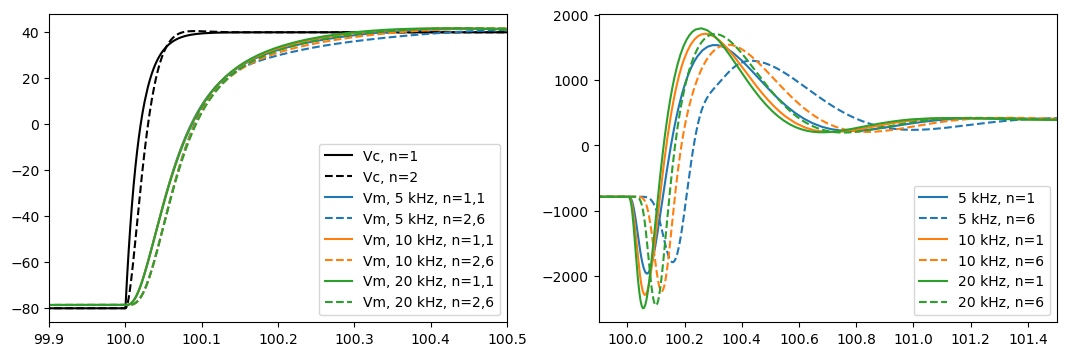

In [24]:
colors = matplotlib.colormaps['tab10'].colors
fig = plt.figure(figsize=(13, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_xlim(99.9, 100.5)
ax2.set_xlim(99.9, 101.5)

ax1.plot(d1.time(), d1['amp.Vc'], 'k', label='Vc, n=1')
ax1.plot(d2.time(), d2['amp.Vc2'], 'k--', label='Vc, n=2')

for i, f1 in enumerate([5, 10, 20]):
    s1.set_constant('amp.f1', f1)
    s2.set_constant('amp.f1', f1)
    s1.reset()
    s2.reset()
    d1 = s1.run(200)
    d2 = s2.run(200)
    ax1.plot(d1.time(), d1['amp.Vm'], color=colors[i], label=f'Vm, {f1} kHz, n=1,1')
    ax1.plot(d2.time(), d2['amp.Vm'], color=colors[i], ls='--', label=f'Vm, {f1} kHz, n=2,6')
    ax2.plot(d1.time(), d1['amp.I_obs'], color=colors[i], label=f'{f1} kHz, n=1')
    ax2.plot(d2.time(), d2['amp.I_obs'], color=colors[i], ls='--', label=f'{f1} kHz, n=6')
ax1.legend()
ax2.legend()

plt.show()

## The effect of the stimulus filter

Filter1 and filter2 set to 30kHz and 100kHz - so pretty much off.
Stimulus filter varied.

In [25]:
def reset(s):
    s.reset()
    s.set_constant('amp.f1', 10)
    s.set_constant('amp.f2', 10)
    s.set_constant('amp.tr', 0.04)

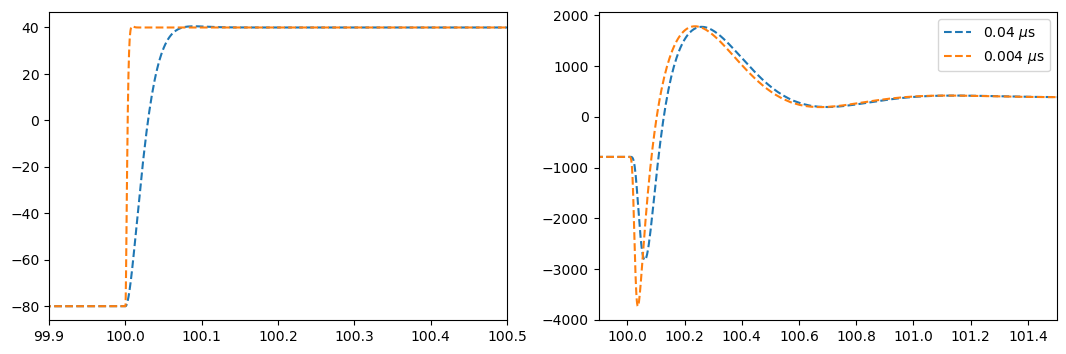

In [33]:
reset(s1)
reset(s2)
s1.set_constant('amp.f1', 30)
s2.set_constant('amp.f1', 30)
s1.set_constant('amp.f2', 100)
s2.set_constant('amp.f2', 100)

fig = plt.figure(figsize=(13, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_xlim(99.9, 100.5)
ax2.set_xlim(99.9, 101.5)

for i, tr in enumerate([0.04, 0.004]):
    #s1.set_constant('amp.tr', tr)
    s2.set_constant('amp.tr', tr)
    #s1.reset()
    s2.reset()
    #d1 = s1.run(200)
    d2 = s2.run(200)

    c = color=colors[i]
    #ax1.plot(d1.time(), d1['amp.Vc'],  color=c, label='Vc, n=1')
    ax1.plot(d2.time(), d2['amp.Vc2'], color=c, ls='--')
    #ax2.plot(d1.time(), d1['amp.I_obs'], color=c, label=f'{f1} kHz, n=1')
    ax2.plot(d2.time(), d2['amp.I_obs'], color=c, ls='--', label=f'{tr} $\\mu$s')
#ax1.legend()
ax2.legend()

plt.show()

## Filtering the output

Patch-clamp amplifiers have several options to filter the data as they record it.
In the HEKA EPC-9 and EPC-10, which are based on the Sigworth design discussed here, there are two built-in analog filters, one of which is always on [Sigworth 1995b](https://doi.org/10.1016/0165-0270(94)00128-4).

Instead of working out the transfer function etc., we'll simulate the application of the analog filter using a digital filter from SciPy.
I'm not 100% sure this is the best way to do it.
Some discussion can be found [on stack exchange](https://dsp.stackexchange.com/questions/8319).

From the manuals, we can see that the EPC-9 uses a 3d order Bessel filter set to 10kHz in most situations, while the EPC-10 uses a 6th order one.

Let's see how this might affect a sodium current, i.e. a Beeler-Reuter sodium current when stepping from -80 to -20mV.

In [1]:
import myokit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
m = myokit.parse_model('''
[[model]]
ina.m = 0.01
ina.h = 0.99
ina.j = 0.98

[engine]
time = 0 [ms]
    in [ms]
    bind time
    
[membrane]
V = 0 [mV]
    in [mV]
    bind pace

[ina]
use membrane.V as V
gNaBar = 4 [mS/cm^2]
    in [mS/cm^2]
gNaC = 0.003 [mS/cm^2]
    in [mS/cm^2]
ENa = 50 [mV]
    in [mV]
INa = (gNaBar * m^3 * h * j + gNaC) * (V - ENa)
    in [uA/cm^2]
    desc: The excitatory inward sodium current
dot(m) =  alpha * (1 - m) - beta * m
    alpha = 1 [1/mV/ms] * (V + 47 [mV]) / (1 - exp(-0.1 [1/mV] * (V + 47 [mV])))
        in [1/ms]
    beta  = 40 [1/ms] * exp(-0.056 [1/mV] * (V + 72 [mV]))
        in [1/ms]
dot(h) =  alpha * (1 - h) - beta * h
    alpha = 0.126 [1/ms] * exp(-0.25 [1/mV] * (V + 77 [mV]))
        in [1/ms]
    beta  = 1.7 [1/ms] / (1 + exp(-0.082 [1/mV] * (V + 22.5 [mV])))
        in [1/ms]
dot(j) =  alpha * (1 - j) - beta * j
    alpha = 0.055 [1/ms] * exp(-0.25 [1/mV] * (V + 78 [mV])) / (1 + exp(-0.2 [1/mV] * (V + 78 [mV])))
        in [1/ms]
    beta  = 0.3 [1/ms] / (1 + exp(-0.1 [1/mV] * (V + 32 [mV])))
        in [1/ms]
''')
m.check_units(myokit.UNIT_STRICT)

In [3]:
p = myokit.Protocol()
p.schedule(start=0, level=-80, duration=100)
p.schedule(start=100, level=-20, duration=20)

In [4]:
s = myokit.Simulation(m, p)
s.run(99)
d = s.run(6, log_interval=1e-4)
d = d.npview()

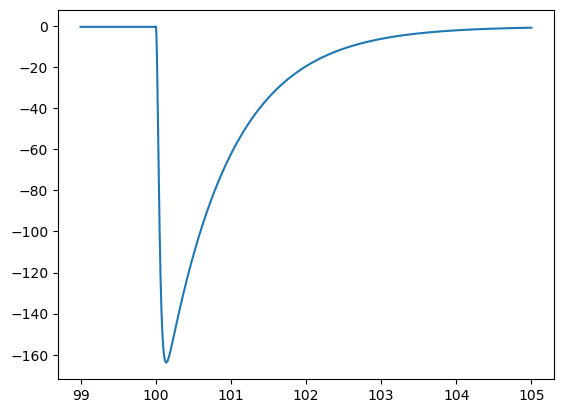

In [5]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(d.time(), d['ina.INa'])
plt.show()

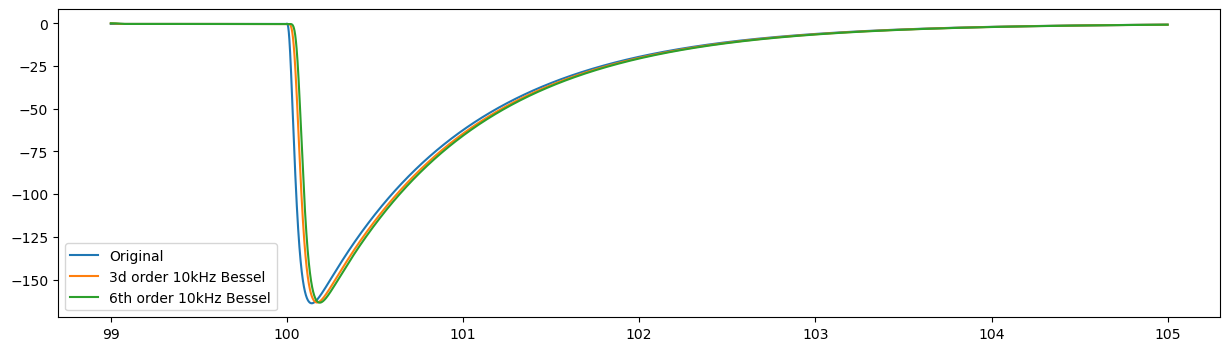

In [6]:
import scipy.signal

t = d.time()
dt = np.mean(t[1:] - t[:-1])   # In ms
fs = 1 / dt    # Sampling frequency, in kHz
fc = 10        # Cut-off frequency, in kHz

def low_pass(data, fc, fs, n=3):
    """ Apply a Bessel low-pass filter with cut-off fc (in Hz). """
    b, a = scipy.signal.bessel(n, fc / (fs / 2), btype='lowpass', norm='mag')
    return scipy.signal.lfilter(b, a, data)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, d['ina.INa'], label='Original')
ax.plot(t, low_pass(d['ina.INa'], fc, fs, 3), label='3d order 10kHz Bessel')
ax.plot(t, low_pass(d['ina.INa'], fc, fs, 6), label='6th order 10kHz Bessel')
ax.legend()
plt.show()

For this fast current, the filtering does seem to have a notable effect.
It's also worth noting that, in the published EPC-9 design, the $R_s$ compensation uses a signal that has been passed through this filter.

For now, we will not include the filter in our model.
See [Kuo & Bean (1994)](https://doi.org/10.1016/0896-6273(94)90335-2) for a real-life mention of the filter's effect on very fast INa properties.